In [8]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [9]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_work = '/work/dnash/SEAK_clim_data/preprocessed/ERA5-IVT/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [10]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

# open precipitation data
fname = path_to_out + 'SEAK_precip_max_{0}_{1}.csv'.format(option, temporal_res)
prec_df = pd.read_csv(fname)
prec_df = prec_df.replace(0, np.NaN) # replace any instance of zero with nan to ignore dates with no precipitation

# open IVT data
df_lst = []
for i, community in enumerate(community_lst):
    fname = path_to_out + 'IVT_ERA5_{0}.csv'.format(community)
    ivt_df = pd.read_csv(fname)
    
    ## calculate IVT direction
    uvec = units.Quantity(ivt_df['uIVT'].values, "m/s")
    vvec = units.Quantity(ivt_df['vIVT'].values, "m/s")
    ivtdir = mpcalc.wind_direction(uvec, vvec)
    ivt_df['ivtdir'] = ivtdir
    ivt_df = ivt_df.drop(['Unnamed: 0'], axis=1) # drop unnecessary vars
    
    if temporal_res == 'hourly':
        ivt_df = ivt_df
    elif temporal_res == 'daily':
        ivt_df.index = ivt_df['time']
        ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time'])) # reset the index as "date" 
        ivt_df = ivt_df.resample('1D').mean(numeric_only=True)
        ivt_df = ivt_df.reset_index() # remove the index
    
    ## append AR data
    fname = path_to_out + 'SEAK_ardates_{0}.csv'.format(temporal_res)
    ar_df = pd.read_csv(fname) # read in AR dates

    # append AR dates to current df
    ivt_df['AR'] = ar_df.AR
    
    ## append impact data
    fname = path_to_out + 'SEAK_impactdates_{0}.csv'.format(temporal_res)
    impact_df = pd.read_csv(fname) # read in impact dates
    # append impact dates to current df
    ivt_df['impact'] = impact_df.IMPACT
    
    # ## append community precipitation data
    ivt_df['prec'] = prec_df[community]
    
    # reset the index as "time"
    ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time']))
    
    ## select the 00, 06, 12, and 18 hour timesteps
    idx = (ivt_df.index.hour == 0) | (ivt_df.index.hour == 6) | (ivt_df.index.hour == 12) | (ivt_df.index.hour == 18)
    ivt_df = ivt_df.loc[idx]
    
    df_lst.append(ivt_df)
    
df_lst[0]


,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec
time,,,,,,,,,,,
1980-01-01,1980-01-01,77.66,58.00,-135.50,0.49,75.10,10.93,184.72,0,0,7.66
1980-01-02,1980-01-02,100.72,58.00,-135.50,-28.84,93.67,11.23,161.07,0,0,29.41
1980-01-03,1980-01-03,62.80,58.00,-135.50,6.30,59.67,9.13,193.02,0,0,7.75
1980-01-04,1980-01-04,19.53,58.00,-135.50,5.74,-16.81,3.08,337.15,0,0,0.08
1980-01-05,1980-01-05,102.21,58.00,-135.50,70.40,-67.56,5.18,323.07,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,91.43,58.00,-135.50,61.35,65.65,7.73,225.77,0,1,2.88
2019-12-28,2019-12-28,221.96,58.00,-135.50,39.06,209.42,12.02,199.91,0,0,40.27
2019-12-29,2019-12-29,89.09,58.00,-135.50,13.36,85.46,9.03,188.47,0,0,7.27


In [11]:
## get list of dates that are Extreme Precip and AR for each community
ardate_lst = []
for i, df in enumerate(df_lst):
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    # idx = (df.AR == 1) & (df.prec > prec_thres) 
    idx = (df.AR == 1) & (df.prec > prec_thres) & (df.index != '2008-02-29 00:00:00') # hack to get rid of the leap day (not in WRF data)
    tmp = df.loc[idx]
    
    ar_dates = tmp.time.values
    ardate_lst.append(tmp.time.values)

## Load IVT Data

In [12]:
%%time
### set the extent of the data for processing
ext1 = [-180., -110., 19, 80] # extent of CIMSS Plots
lonmin, lonmax, latmin, latmax = ext1

## This is a lot of data so pulling only dates in ardate_lst
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

ds_lst = []
for i, community in enumerate(community_lst):
    print('Processing', community)
    ardates = ardate_lst[i]
    ## make dataframe of dates and add year, month, day info
    d = {'date': ardates}
    df = pd.DataFrame(data=d)
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month.map("{:02d}".format)
    df['day'] = pd.DatetimeIndex(df['date']).day.map("{:02d}".format)
    
    ## now iterate through the dates and only open the files for the dates we want
    filenames = []
    for index, row in df.iterrows():
        yr = row['year']
        mon = row['month']
        day = row['day']
        filenames.append('/data/downloaded/Reanalysis/ERA5/IVT/{0}/ERA5_IVT_{0}{1}{2}.nc'.format(yr, mon, day))
    
    ## now open all those files and combine into one ds    
    era = xr.open_mfdataset(filenames, combine='by_coords', preprocess=preprocess, parallel=False)
    if temporal_res == 'hourly':
        era = era
    elif temporal_res == 'daily':
        era = era.resample(time="1D").mean('time')
    ds_lst.append(era)


Processing Hoonah
Processing Skagway
Processing Klukwan
Processing Yakutat
Processing Craig
Processing Kasaan
CPU times: user 56.4 s, sys: 10.1 s, total: 1min 6s
Wall time: 5min 35s


In [18]:
%%time
## make a dataset for each community subset to its AR dates
ds_lst_comp = []
for i, ds in enumerate(ds_lst):
    print('Processing {0}'.format(community_lst[i]))
    tmp = ds.mean('time')
    tmp = tmp.load()
    ds_lst_comp.append(tmp)
    
ds_lst_comp[0]

Processing Hoonah
Processing Skagway
Processing Klukwan
Processing Yakutat
Processing Craig
Processing Kasaan
CPU times: user 8min 51s, sys: 10min 54s, total: 19min 46s
Wall time: 2h 46min 6s


<xarray.Dataset>
Dimensions:  (lat: 245, lon: 281)
Coordinates:
  * lat      (lat) float64 19.0 19.25 19.5 19.75 20.0 ... 79.25 79.5 79.75 80.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... -110.5 -110.2 -110.0
Data variables:
    IVT      (lat, lon) float64 251.4 250.9 250.4 250.0 ... 36.52 36.47 36.43
    uIVT     (lat, lon) float64 -204.7 -204.2 -203.8 ... 6.896 6.831 6.766
    vIVT     (lat, lon) float64 -24.03 -24.29 -24.61 ... -2.642 -2.628 -2.614
    IWV      (lat, lon) float64 34.21 34.15 34.1 34.07 ... 4.063 4.061 4.058

## Plot IVT Composites

In [22]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ds_lst[0].lat.values
lons = ds_lst[0].lon.values
dx = np.arange(lons.min().round(),lons.max().round()+10,10)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

# ext1 = [-141., -130., 54., 61.] # extent of SEAK
ext1 = [-180., -110., 19, 80] # extent of CIMSS Plots

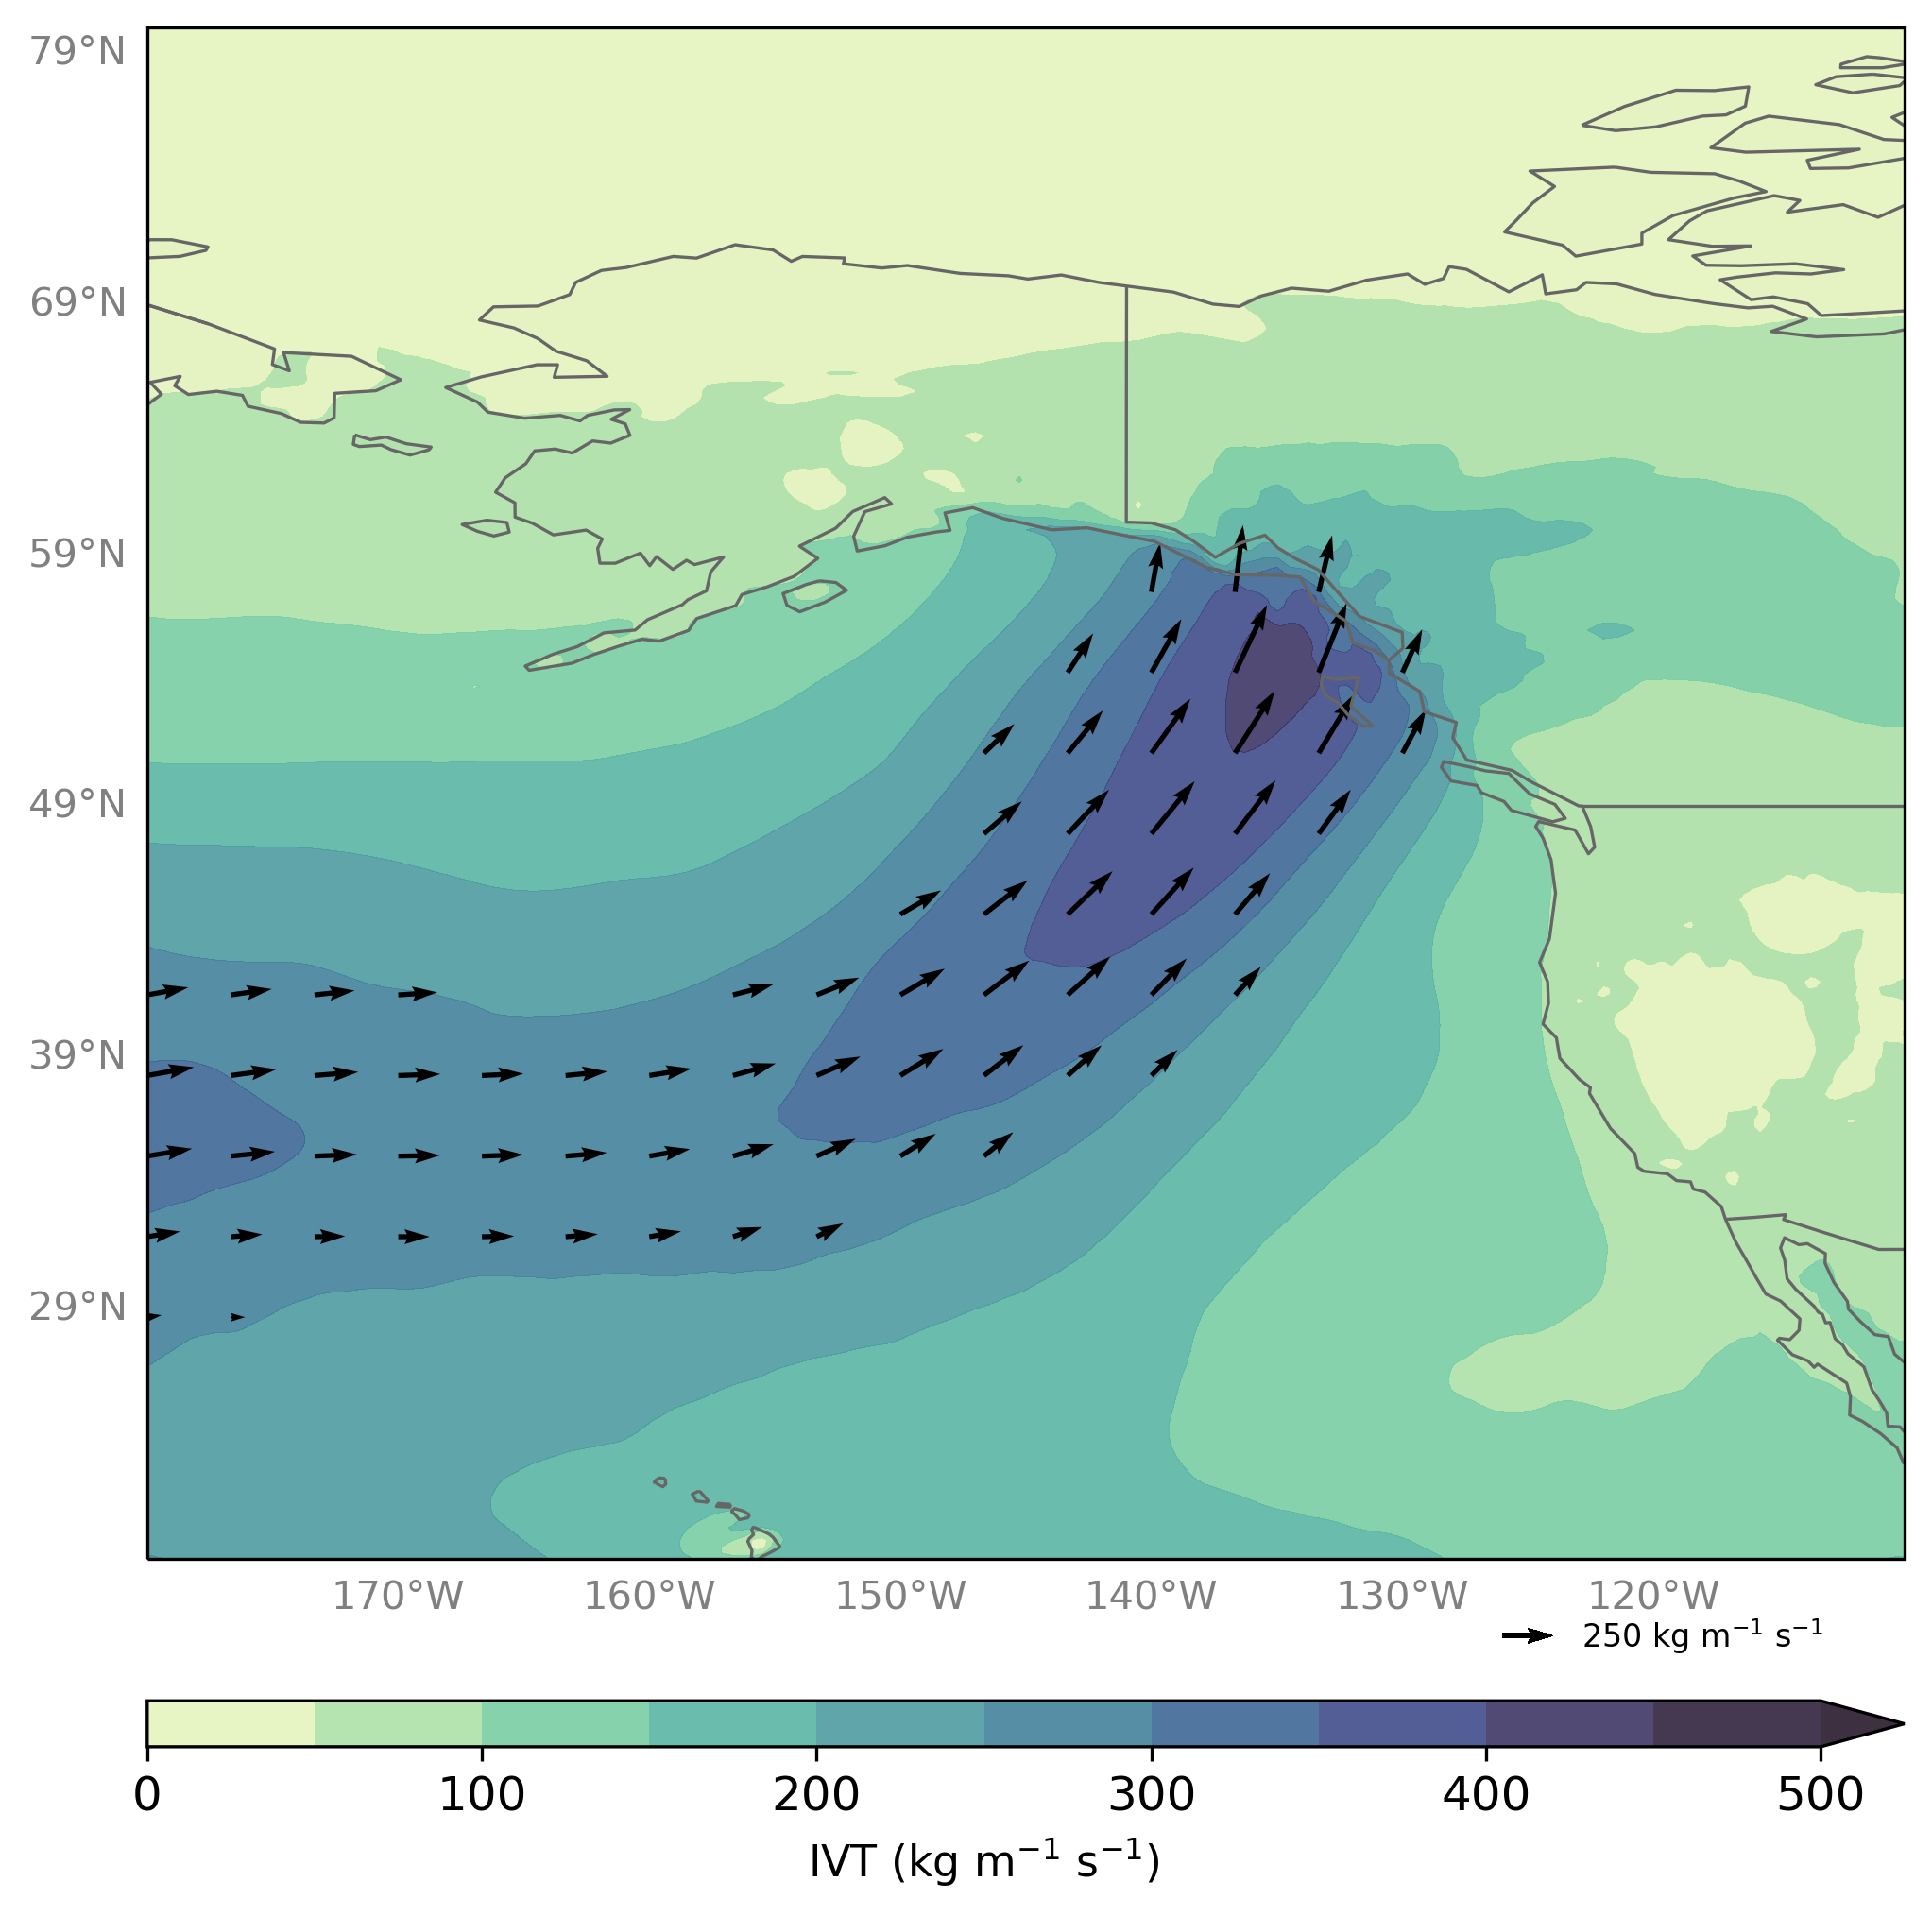

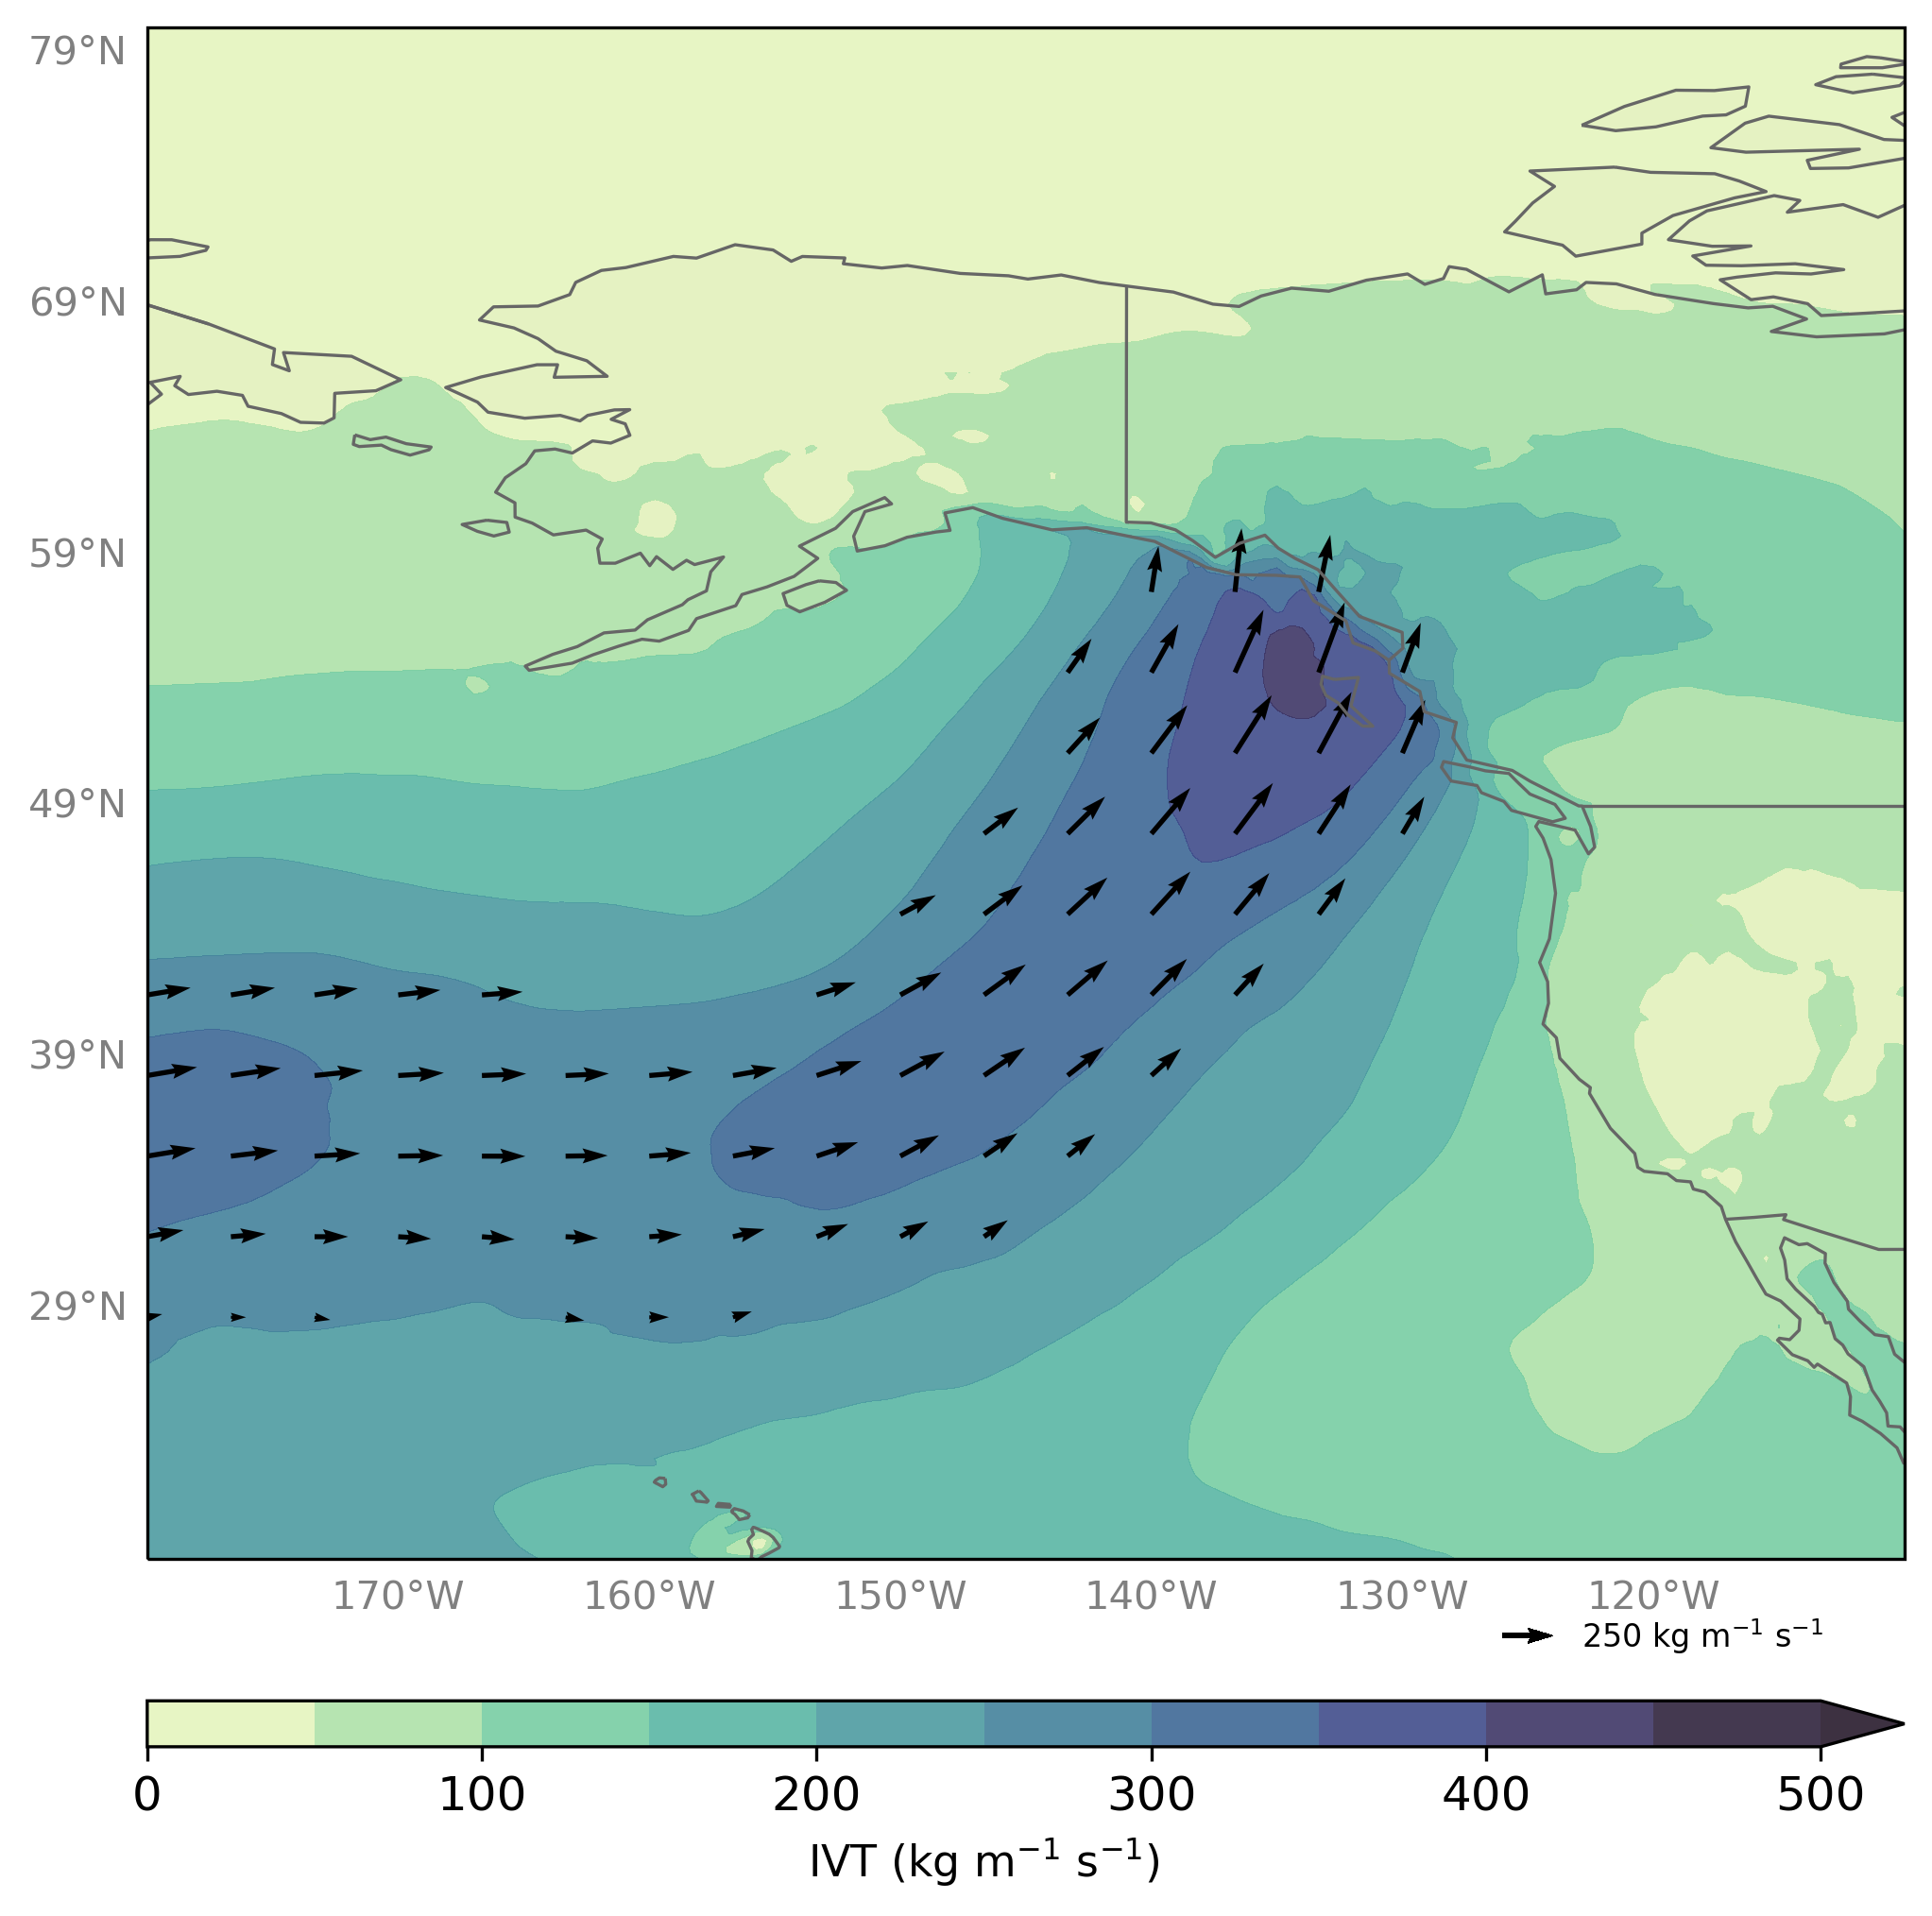

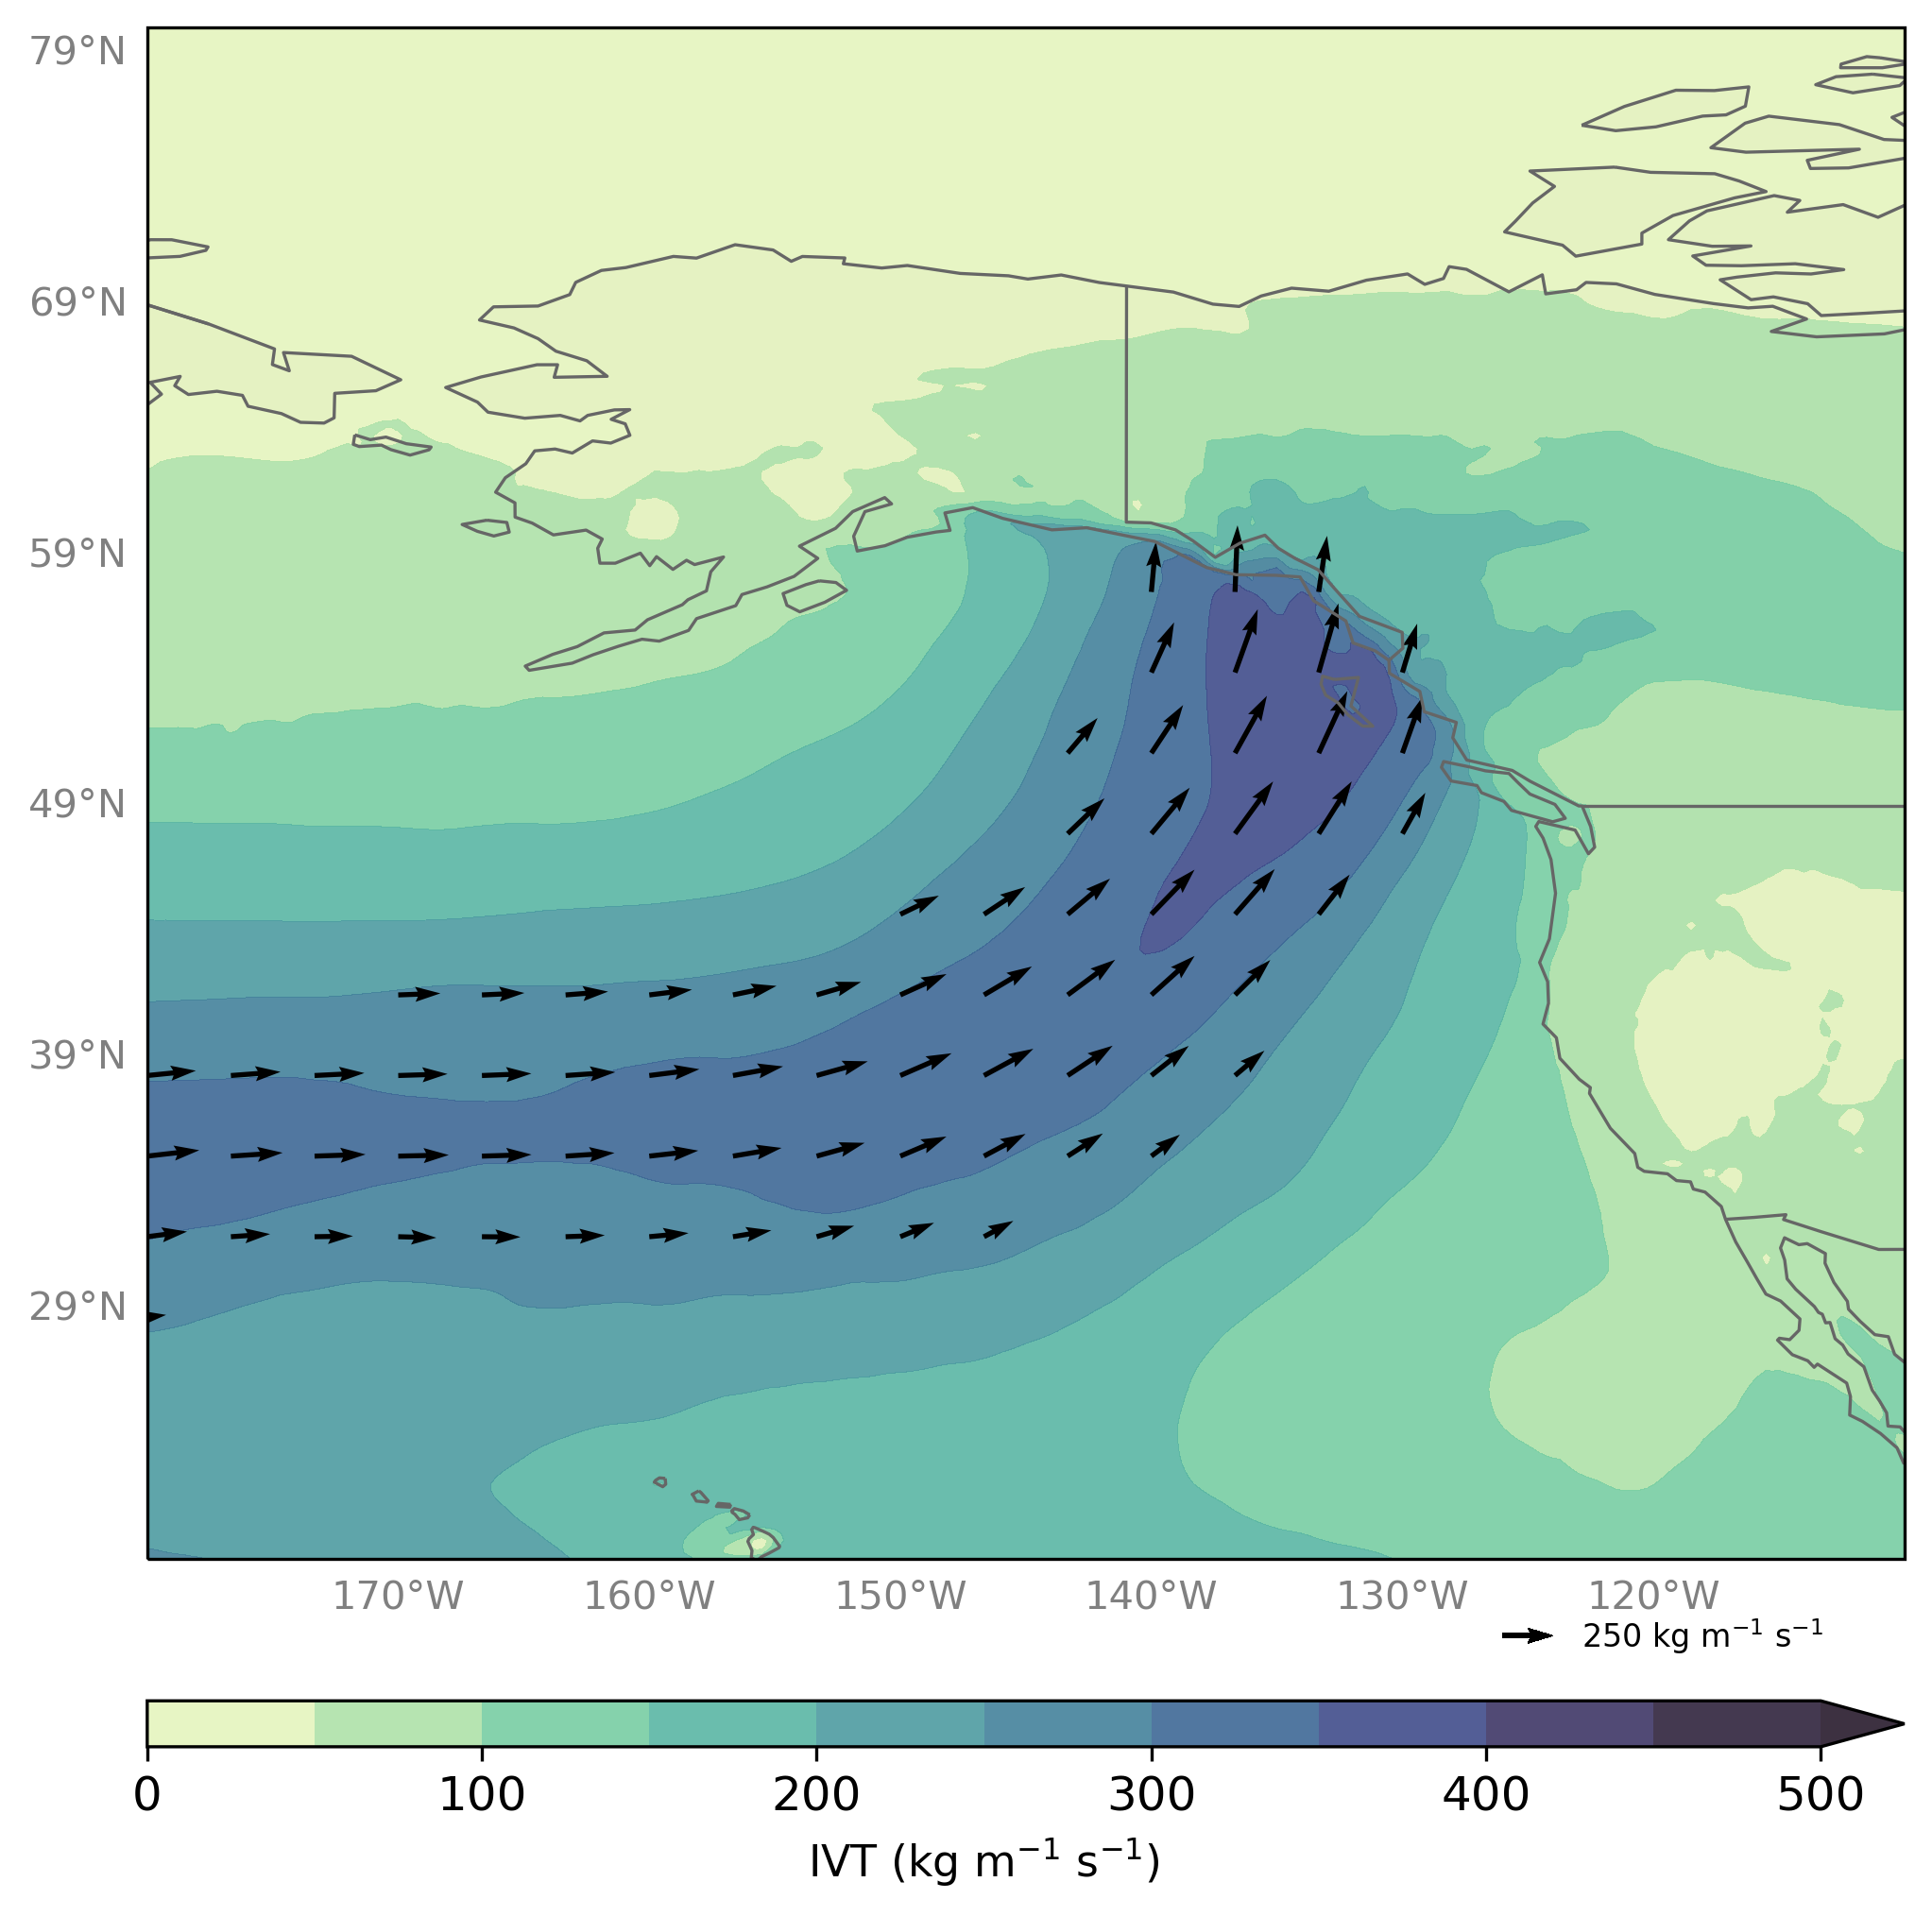

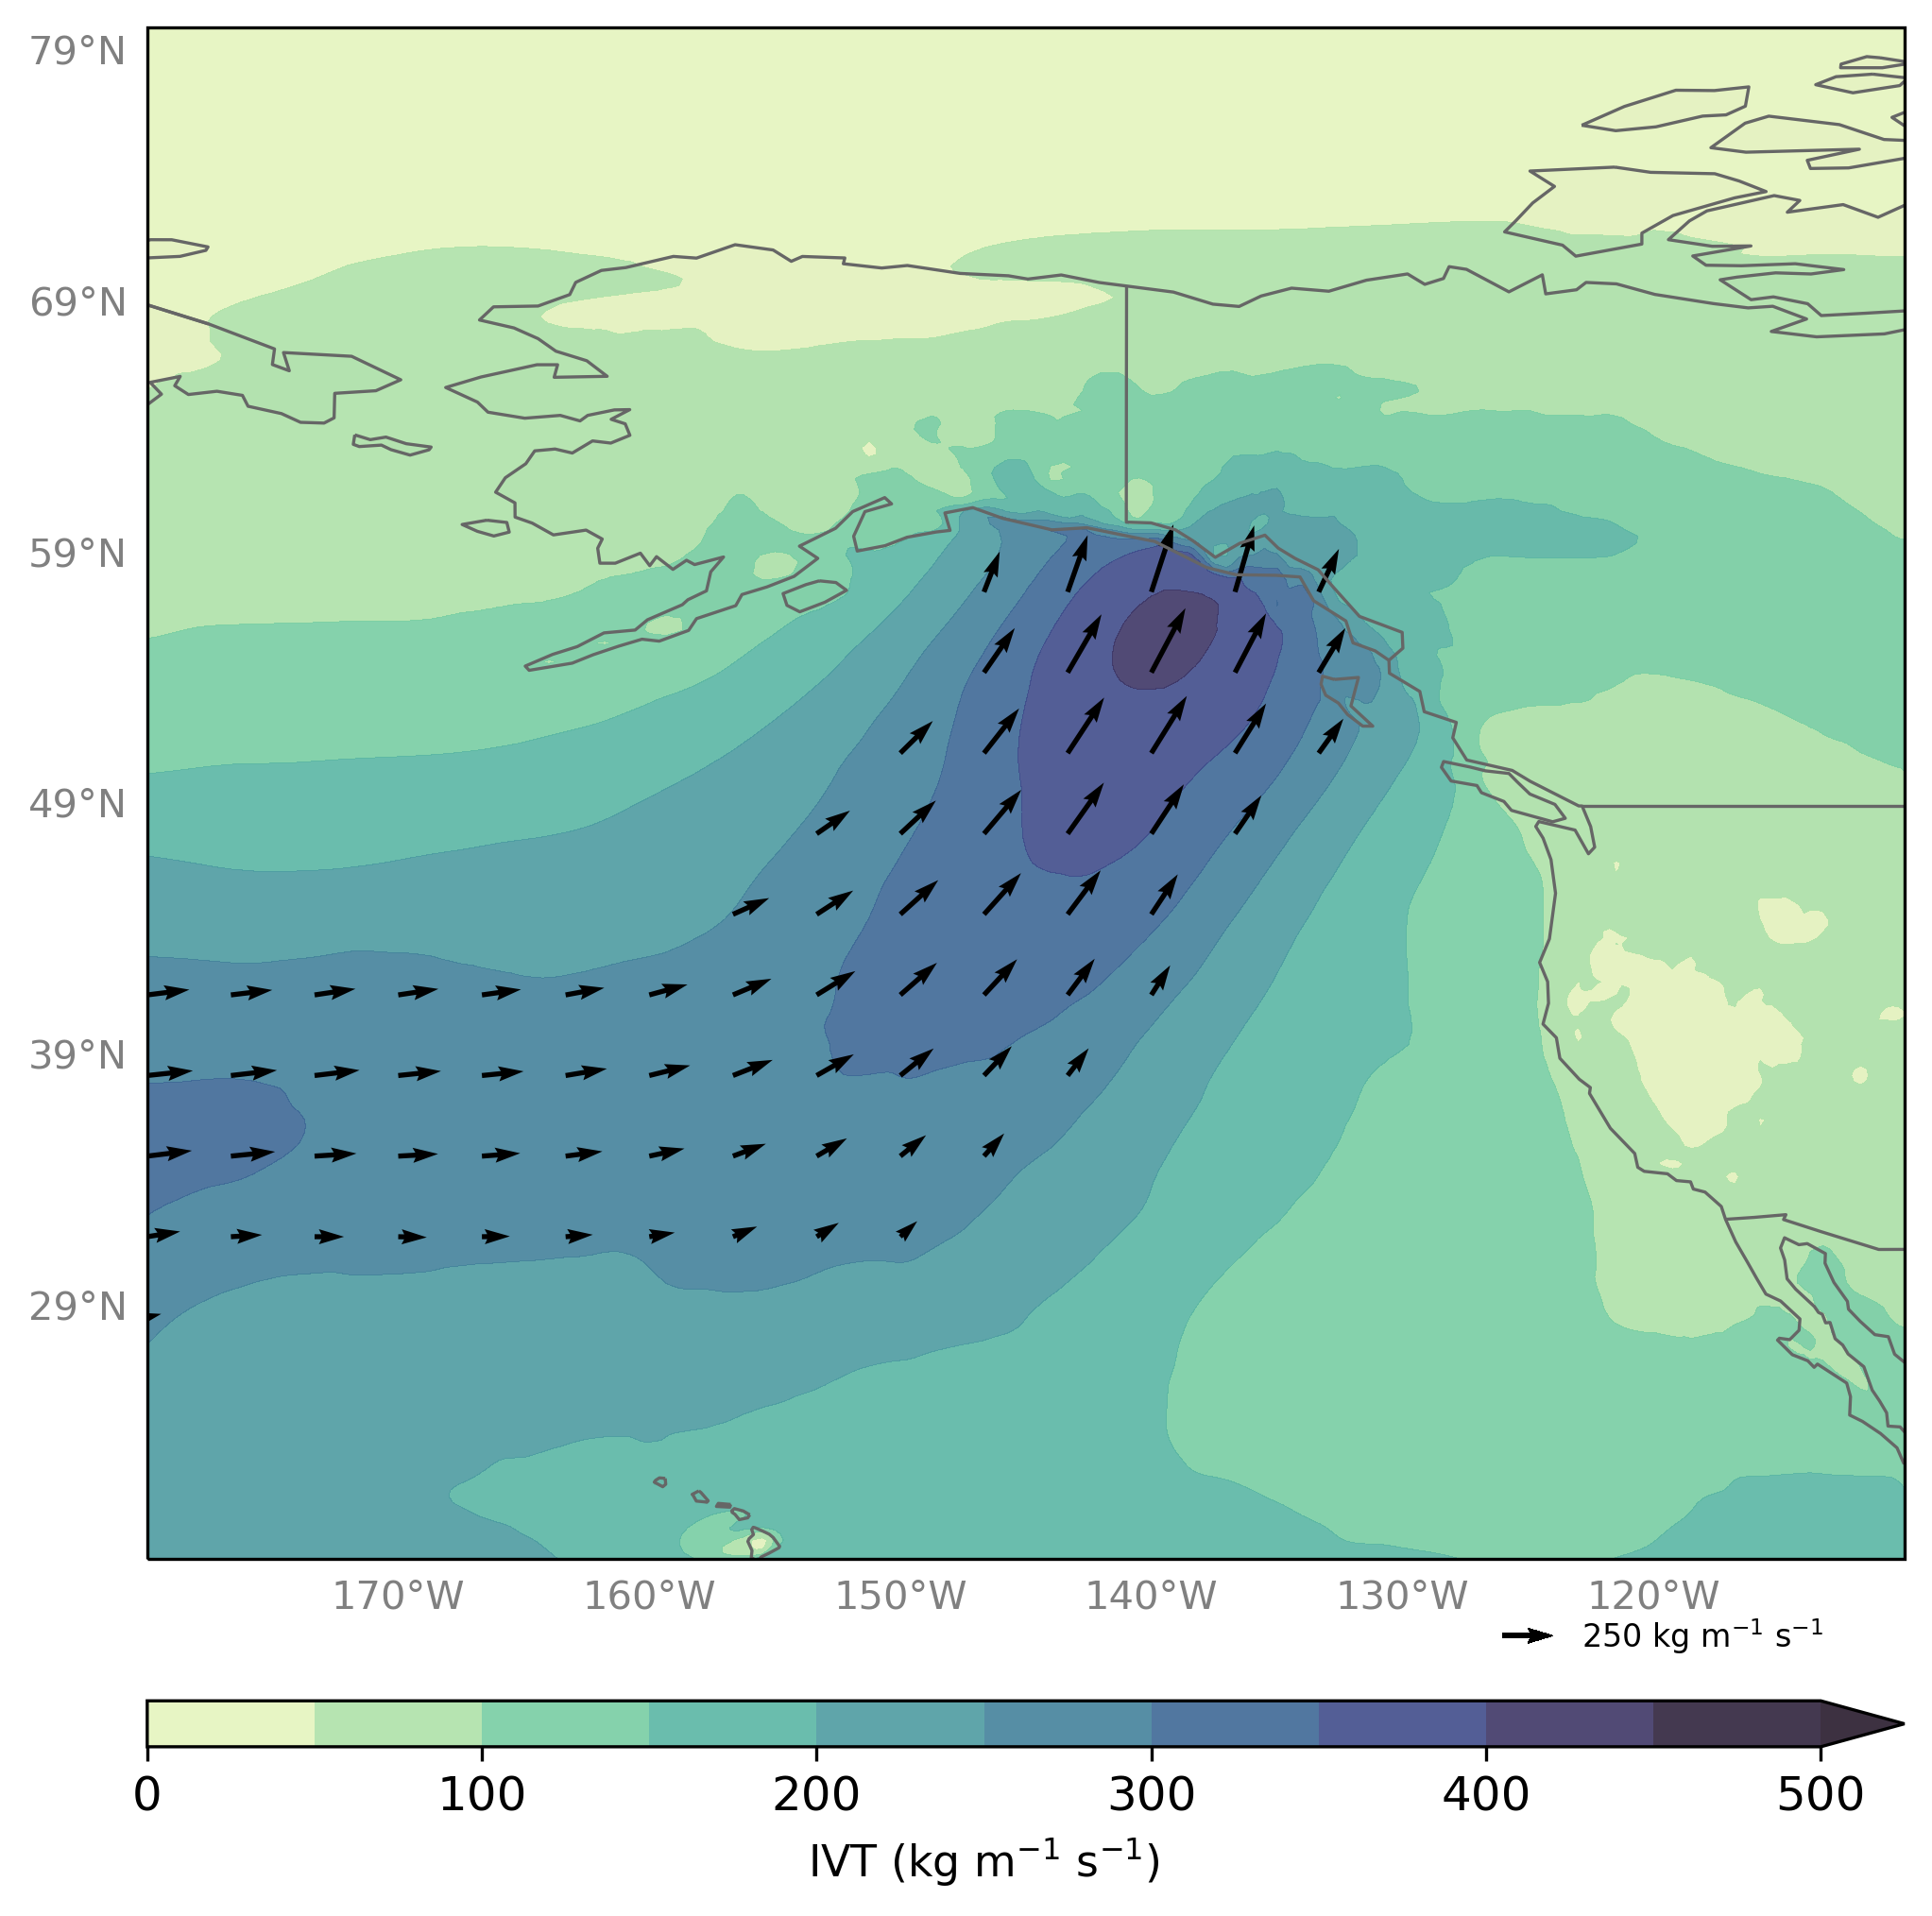

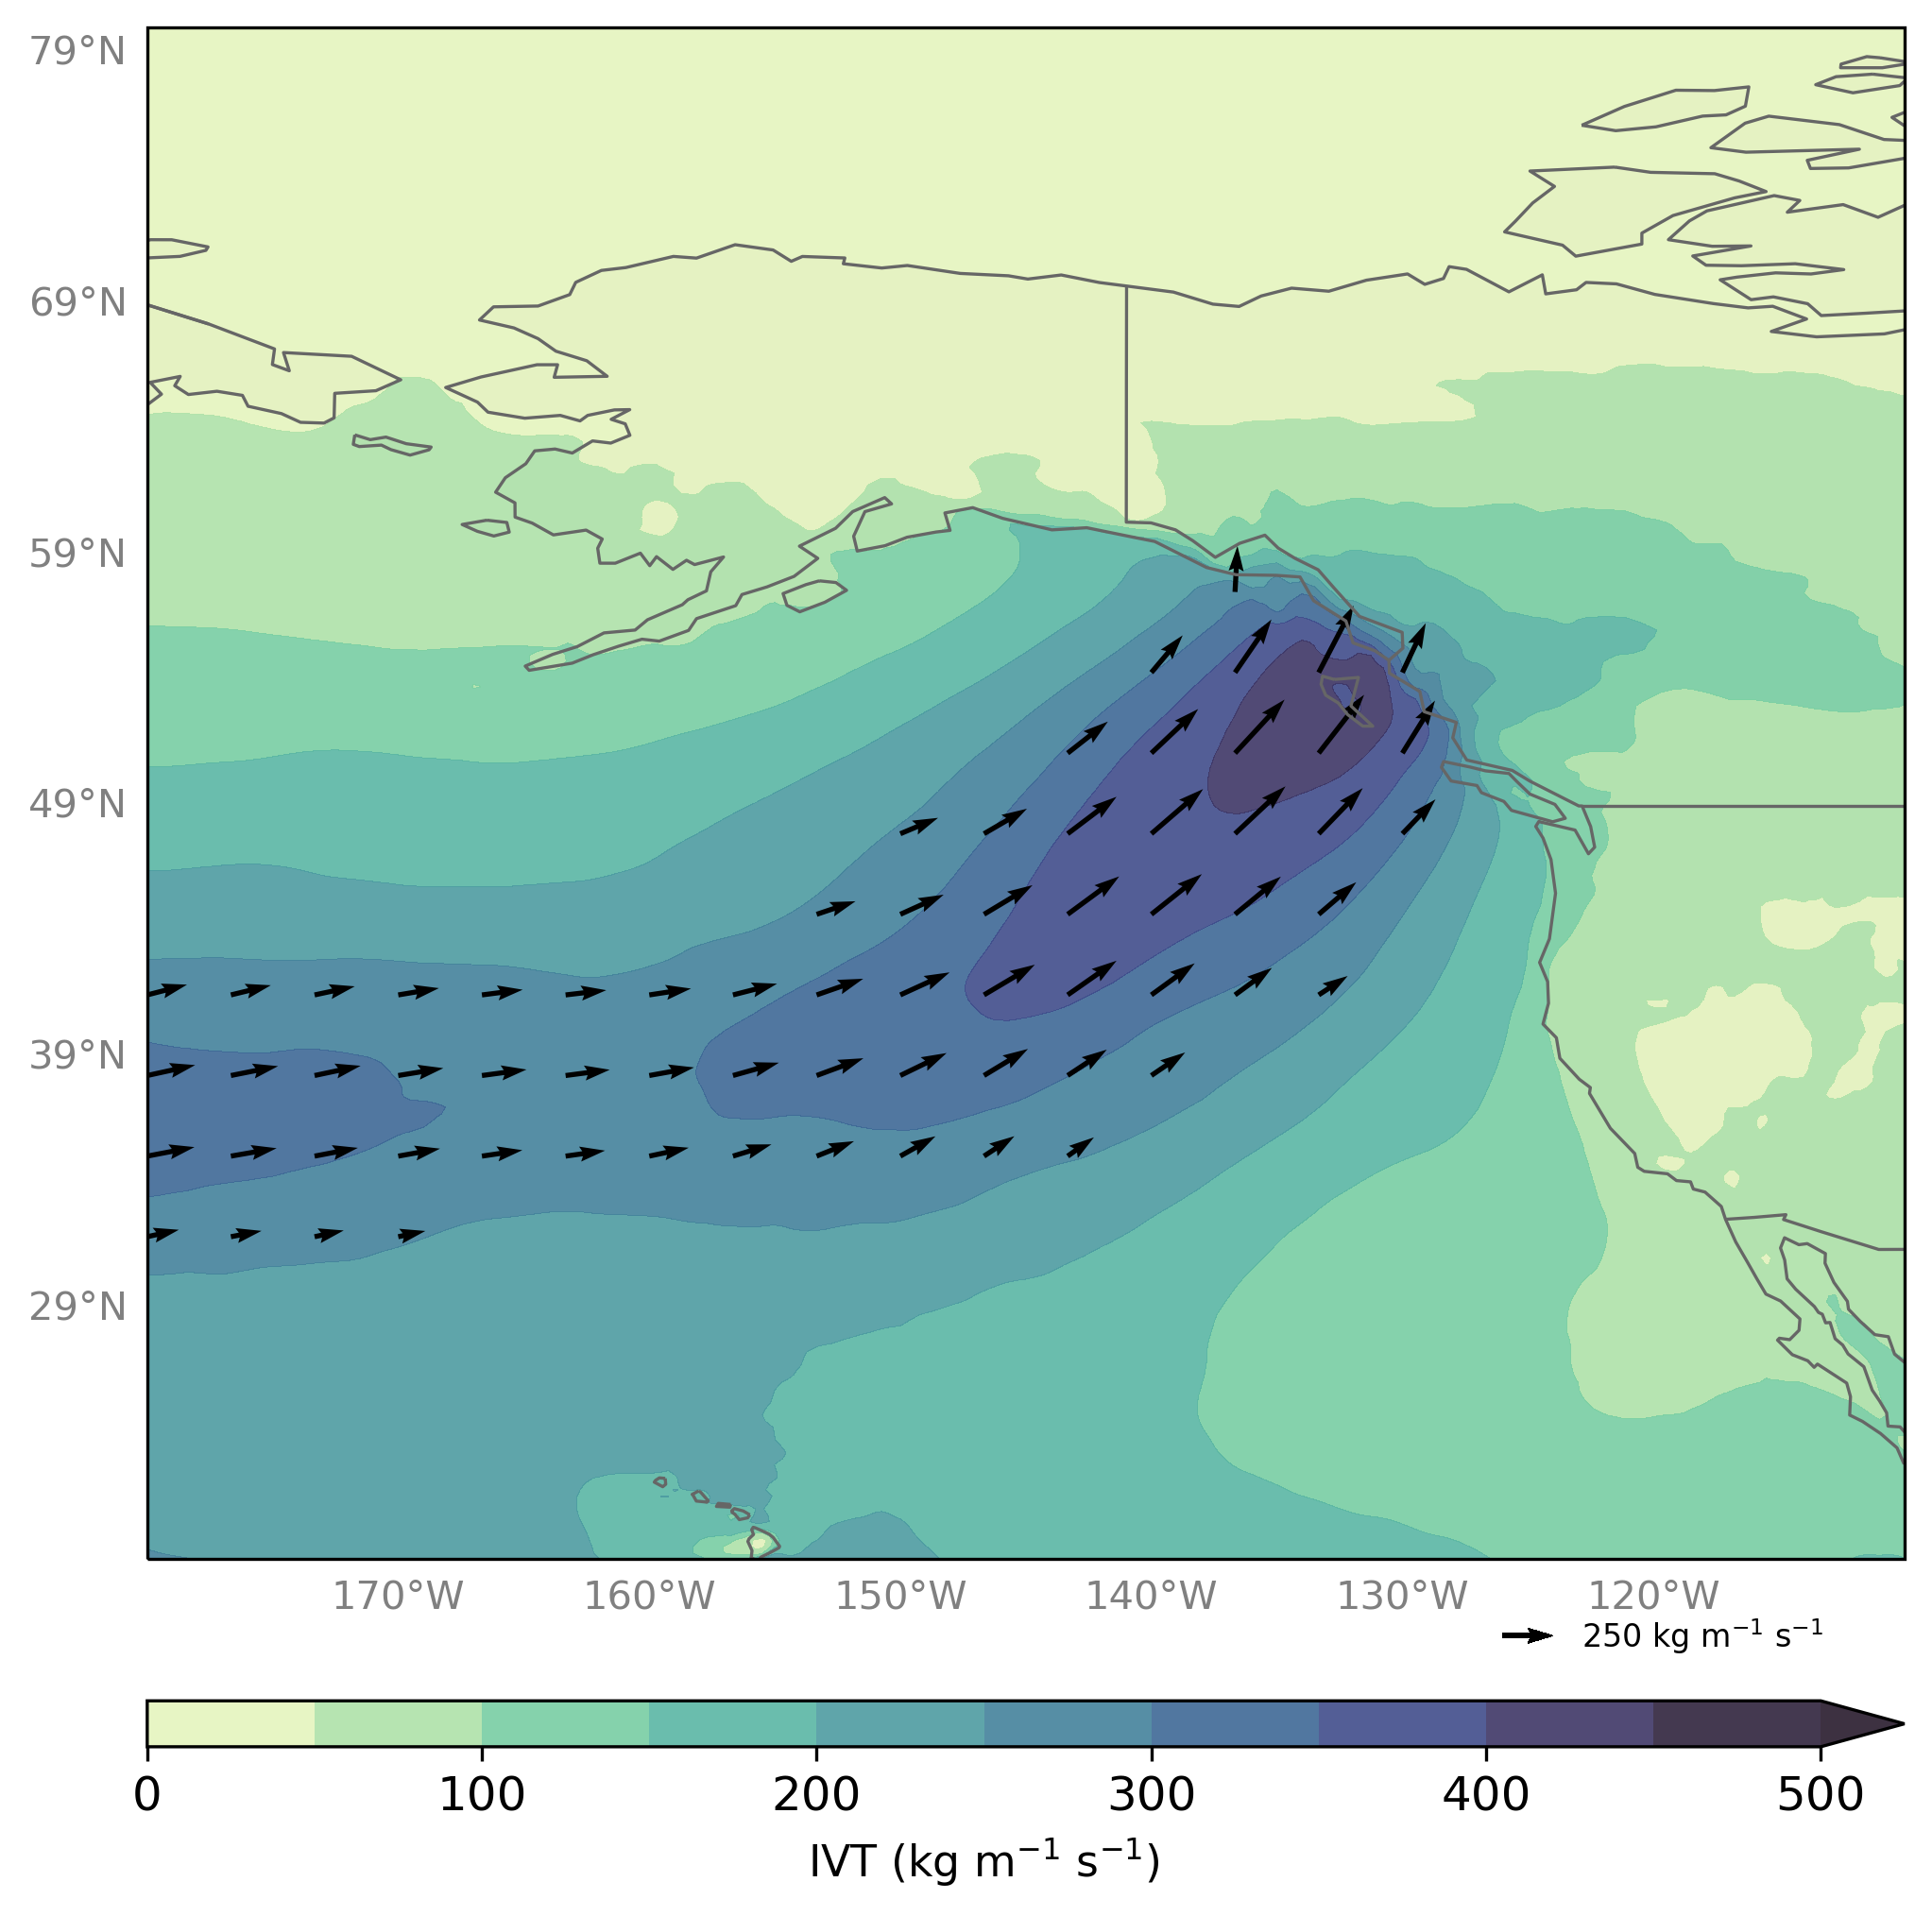

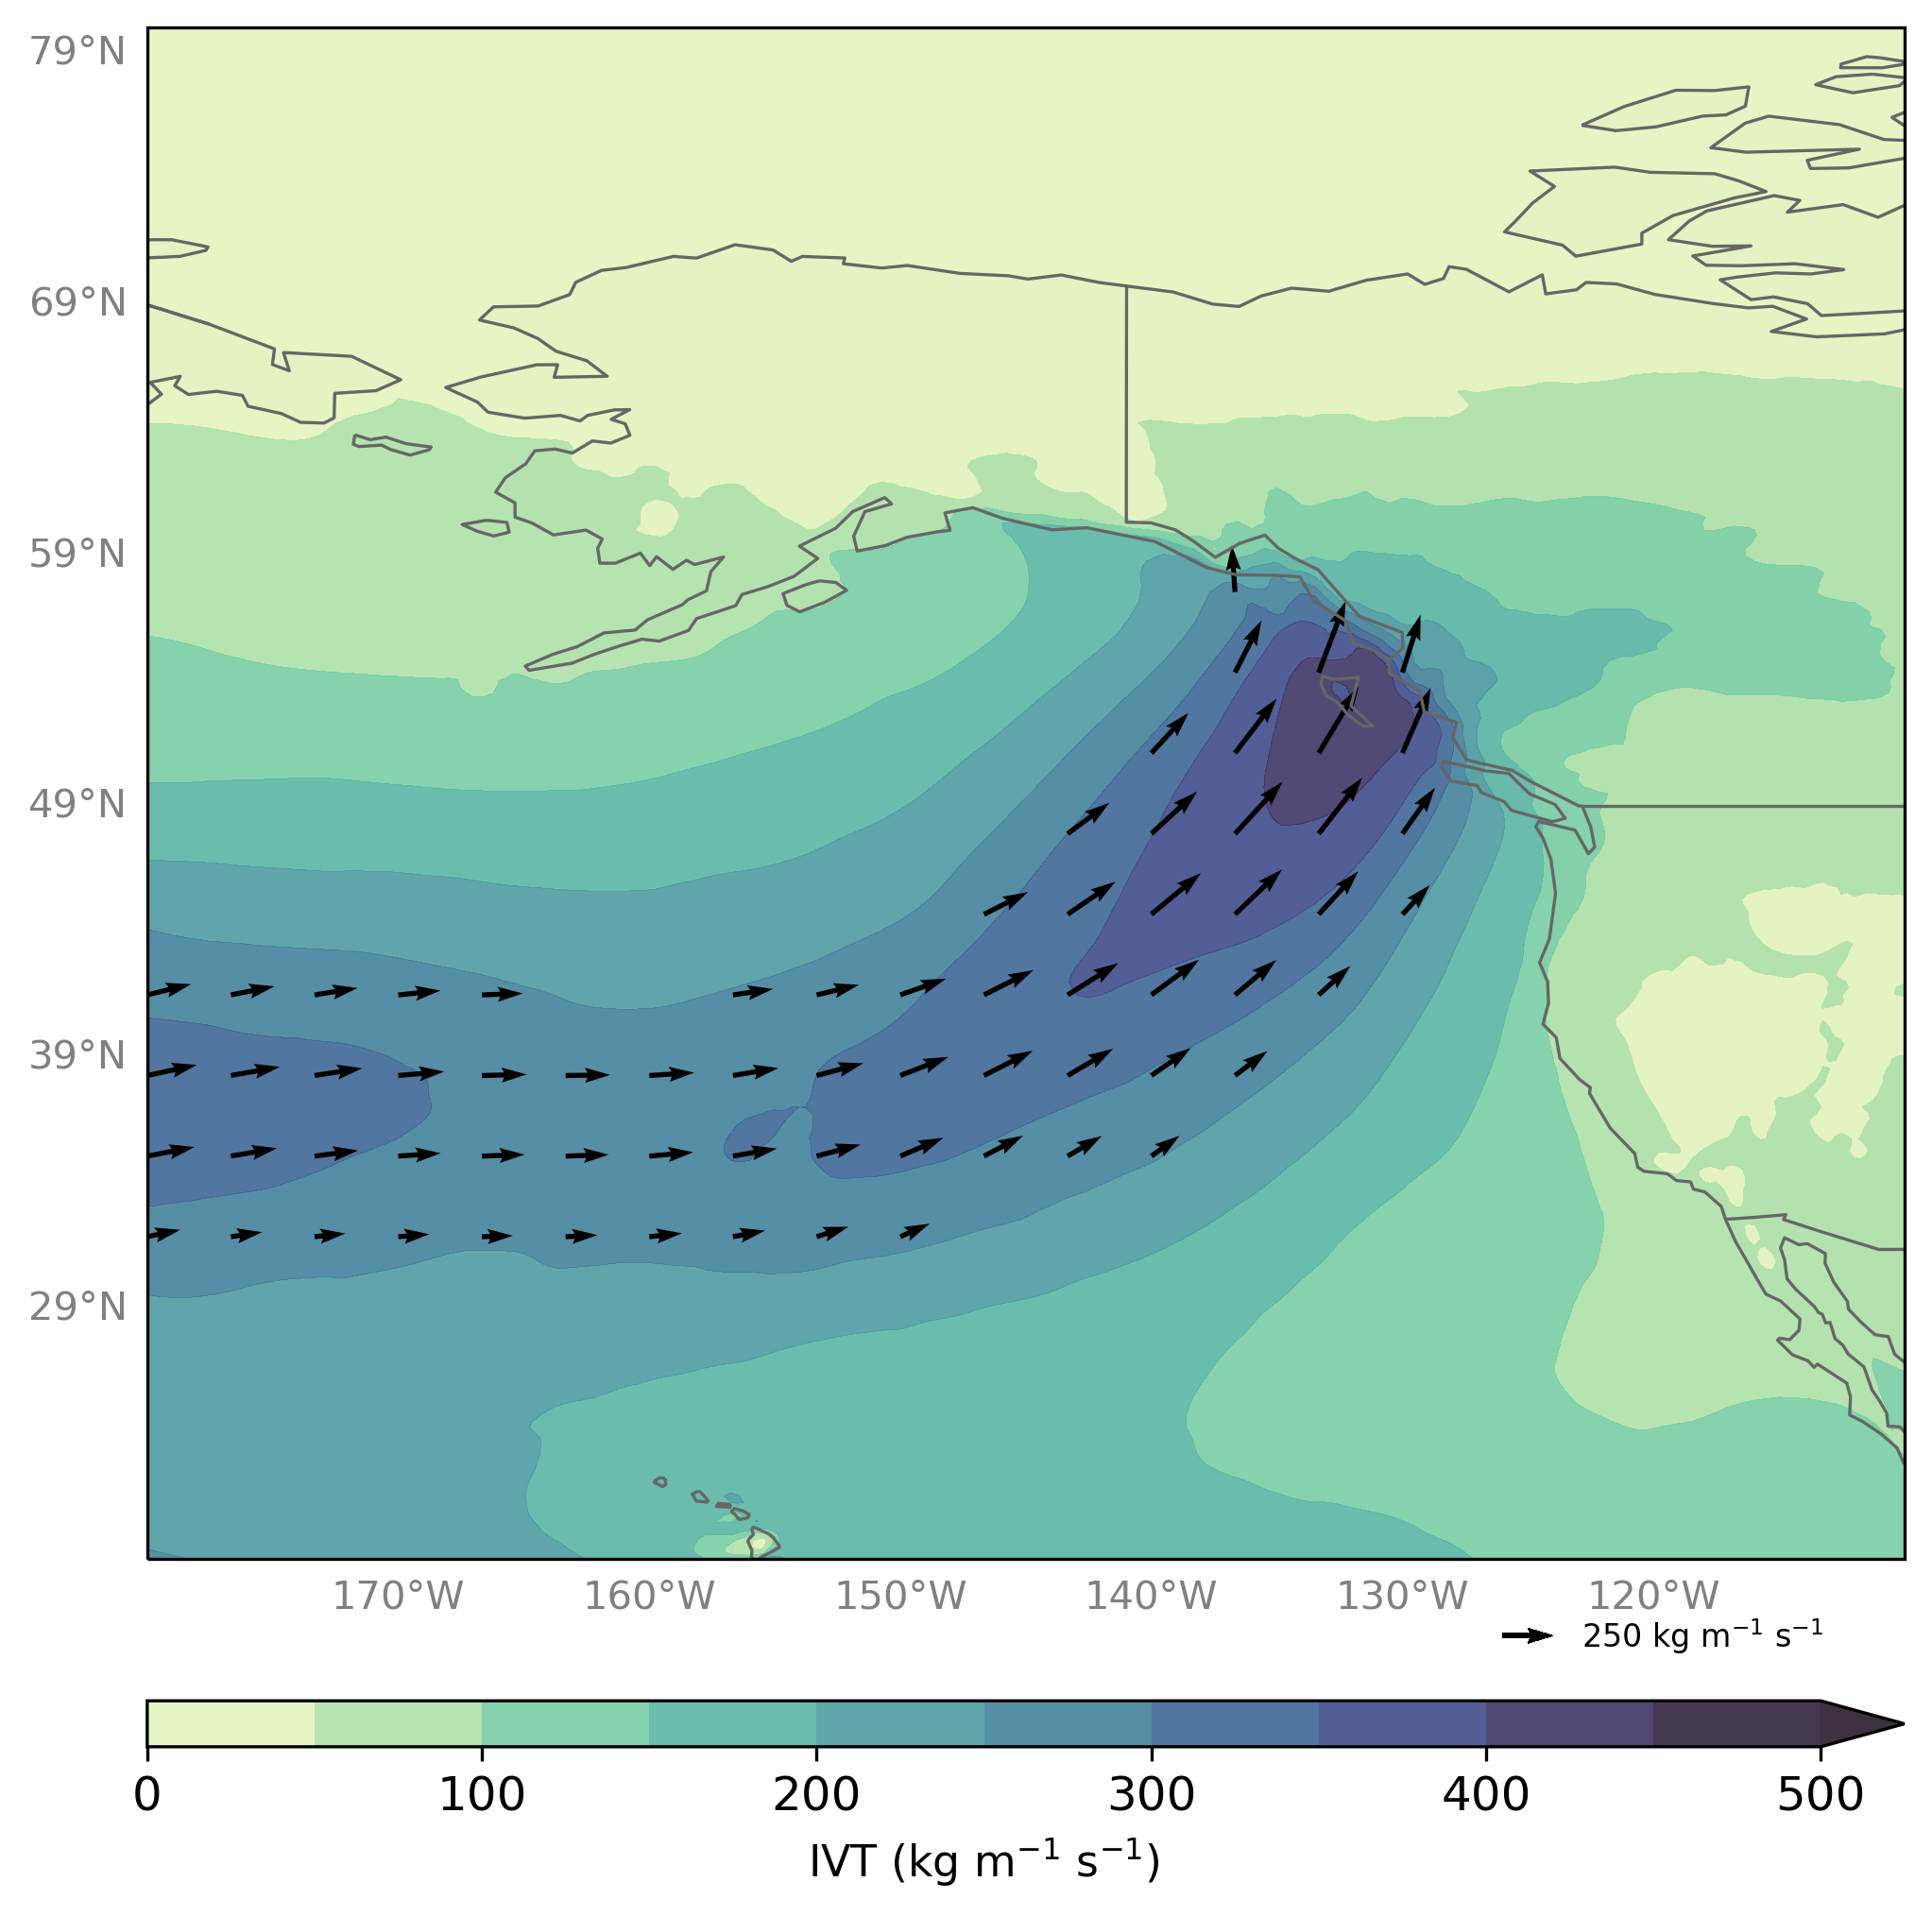

In [27]:
for i, ds in enumerate(ds_lst_comp):
    community = community_lst[i]
    # Create figure
    fig = plt.figure(figsize=(8, 12))
    fig.dpi = 300
    fname = path_to_figs + 'extreme-AR_IVT_composite_{0}'.format(community)
    fmt = 'png'

    nrows = 1
    ncols = 1

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.05, cbar_size='3%',label_mode='')


    for k, ax in enumerate(axgr):
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False)

        # Contour Filled
        ivt = ds.IVT.values
        clevs = np.arange(0, 550, 50) # levels for IVT
        cmap = cmo.deep # cmap for IVT
        cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                         levels=clevs, cmap=cmap, alpha=0.9, extend='max')

        # Wind barbs / vectors 
        uvec = ds.uIVT.values
        vvec = ds.vIVT.values
        uvec_mask = ds.uIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
        vvec_mask = ds.vIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
        
        Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                  color='k', regrid_shape=20,
                  angles='xy', scale_units='xy', scale=125, units='xy')
        
        # ax.set_title(community, loc='left')


    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
    cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
    cb.ax.tick_params(labelsize=12)
    
    # quiver key
    qk = ax.quiverkey(Q, 0.8, -0.05, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 8.0})

    fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

    # Show
    plt.show()

In [24]:
%%time
for i, ds in enumerate(ds_lst_comp):
    community = community_lst[i]
    # write to netCDF
    fname = os.path.join(path_to_work, 'ERA5_IVT_daily_{0}.nc'.format(community))
    ds.to_netcdf(path=fname, mode = 'w', format='NETCDF4')

CPU times: user 164 ms, sys: 77.6 ms, total: 242 ms
Wall time: 1.65 s
